# Observatorium


Svrha je ove *Python* bilježnice malo pregledati (opservirati) skup podataka na osnovu kojeg treba izgraditi model kao rješenje zadatka za natjecanje *Mozgalo* 2019. godine.

Pripremimo prvo okruženje.


In [1]:
# Pripremi Python okruzenje.

# IPython
from IPython import *
from IPython.display import *

# Standardna Python biblioteka
import math
import os
import six
import sys
import time

# SciPy paketi
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
from mpl_toolkits.mplot3d.axes3d import Axes3D # 3-dimenzionalna grafika

# Postavi prikaz grafova unutar biljeznice.
%matplotlib inline

# Postavi stil grafova na `ggplot'.
plt.style.use('ggplot')

# Inicijaliziraj ispis simbolickog racuna.
sym.init_printing()


## Učitavanje podataka


Podatke ćemo iz datoteke *training_dataset_enc.csv* učitati kao `pandas.DataFrame` pozivom funkcije `pandas.read_pickle` odnosno `pandas.read_csv`. Pokretanjem sljedećih programskih linija može se primijetiti da učitavanje podataka iz *CSV* datoteke traje jako dugo zato što redaka u tablici ima više od $ 5 $ milijuna, stoga ćemo prvo pokušati otvoriti *pickle*, a, ako datoteka koju tražimo ne postoji, tek ćemo onda otvarati *CSV* i odmah ćemo učitanu tablicu spremiti kao *pickle* datoteku za kasnije brže učitavanje. Izmjerit ćemo i vrijeme potrebno za učitavanje podataka jer se iz izmjerenih vremena jasno vidi vremenska optimizacija učitavanja podataka.


In [2]:
##  UCITAVANJE SKUPA PODATAKA
##
##  S obzirom na to da je skup podataka vrlo velik (5 193 124 redaka), mjerit
##  cemo i vrijeme potrebno za njegovo ucitavanje.  Podatci bi se, medutim, puno
##  brze ucitali da se datumi ne parsiraju, nego da ostanu stringovi, ali
##  vjerojatno ce nam datumi ionako biti potrebni u datumskom obliku pa ih je
##  bolje odmah takve i ucitati.

# Pocni mjeriti vrijeme.
t0 = time.time()


# Ucitaj skup podataka.  Prvo se pokusava ucitati pickle iz datoteke
# `training_dataset_enc.pkl', a, ako ta datoteka ne postoji, onda se ucitava
# tablica u CSV obliku iz `training_dataset_enc.csv' i odmah se sprema pickle u
# datoteku `training_dataset_enc.pkl' za brze ucitavanje ubuduce.
df = None
try:
    df = pd.read_pickle('training_dataset_enc.pkl')
except FileNotFoundError:
    df = pd.read_csv(
        'training_dataset_enc.csv',
        index_col = 0,
        parse_dates = [
            'DATUM_IZVJESTAVANJA',
            'DATUM_OTVARANJA',
            'PLANIRANI_DATUM_ZATVARANJA',
            'DATUM_ZATVARANJA'
        ],
        infer_datetime_format = True,
        true_values = ['Y'],
        false_values = ['N']
    )
    df.to_pickle('training_dataset_enc.pkl')

# Zavrsi mjerenje vremena.
t1 = time.time()

# Izracunaj vremenski period od t0 do t1 u sekundama.
d = float(t1 - t0)

# Ispisi vrijeme.
print(
    'Trajanje ucitavanja: {h:d}h {m:02d}m {s:06.3f}s ({S:.3f}s)'.format(
        h = int(math.floor(d / 3600)),
        m = int(math.floor((d - 3600 * int(math.floor(d / 3600))) / 60)),
        s = d - 60 * int(math.floor(d / 60)),
        S = d
    )
)

# Oslobodi memoriju.
del d
del t0
del t1


/home/aster/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Trajanje ucitavanja: 0h 04m 30.086s (270.086s)


## Jednostavni pregled podataka


Sada kada su podatci učitani, promotrimo malo kakvi su. Pregledat ćemo u kakvom su formatu podatci spremljeni, kako izgledaju neki od prvih i zadnjih redaka u tablici, a zatim ćemo nad svim stupcima izvršiti minimalnu deskriptivnu statistiku.


In [3]:
# Opis `feature'-a
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5193124 entries, 0 to 5193123
Data columns (total 18 columns):
Unnamed: 0.1                      int64
DATUM_IZVJESTAVANJA               datetime64[ns]
KLIJENT_ID                        int64
OZNAKA_PARTIJE                    int64
DATUM_OTVARANJA                   datetime64[ns]
PLANIRANI_DATUM_ZATVARANJA        datetime64[ns]
DATUM_ZATVARANJA                  datetime64[ns]
UGOVORENI_IZNOS                   float64
STANJE_NA_KRAJU_PRETH_KVARTALA    float64
STANJE_NA_KRAJU_KVARTALA          float64
VALUTA                            int64
VRSTA_KLIJENTA                    int64
PROIZVOD                          object
VRSTA_PROIZVODA                   object
VISINA_KAMATE                     float64
TIP_KAMATE                        object
STAROST                           int64
PRIJEVREMENI_RASKID               bool
dtypes: bool(1), datetime64[ns](4), float64(4), int64(6), object(3)
memory usage: 718.1+ MB


In [4]:
# Prvih nekoliko redaka
df.head()


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
0,2,2013-12-31,412140,7146814,2012-08-27,2018-04-30,NaT,629155.97,639373.81,641562.01,2,1420,TM0109,L,1.50,A,22,False
1,5,2013-12-31,772139,5521579,2010-06-11,2017-06-30,NaT,46000.00,28481.94,26887.19,1,1410,FL0801,A,9.70,B,38,False
2,6,2013-12-31,481985,7443823,2013-01-23,2018-02-28,NaT,44679.50,44908.40,45062.09,2,1550,FD0100,L,3.10,A,37,False
3,9,2013-12-31,139014,6511639,2011-09-16,2016-09-30,NaT,29959.15,19691.64,18285.89,2,1410,FL0801,A,7.95,B,49,False
4,10,2013-12-31,952566,6143123,2011-05-23,2014-05-31,NaT,100000.00,24797.93,15685.33,1,1410,FL0801,A,9.70,B,35,False


In [5]:
# Zadnjih nekoliko redaka
df.tail()


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
5193119,8664511,2011-03-31,91448,5952541,2011-03-22,NaT,NaT,228977.87,NaN,228867.02,2,1410,TM0109,L,3.90,A,46,False
5193120,8664513,2011-03-31,642422,5615789,2010-08-11,2012-08-31,NaT,10420.82,8945.30,7638.62,2,1410,FL1600,A,4.00,C,62,False
5193121,8664514,2011-03-31,585010,1267220,2003-10-20,2028-10-31,NaT,486353.44,419939.30,416042.95,2,1410,FL1301,A,8.50,C,41,False
5193122,8664517,2012-03-31,330608,1413623,2006-10-27,2013-10-31,NaT,102421.36,40550.36,37387.95,4,1410,FL1201,A,4.95,C,40,False
5193123,8664531,2012-03-31,78952,6735617,2012-02-09,NaT,NaT,3000.00,NaN,3000.00,1,1410,TM0109,L,3.70,A,69,False


Definirat cemo i neke funkcije koje ce nam olaksati jednostavnu analizu stupaca.


In [6]:
def analiziraj_num_stupac (col):
    """
    Saznaj neke podatke o stupcu s numerickim vrijednostima.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi biti numerickog tipa.  Ako ti
    zahtjevi nisu ispunjeni, ponasanje funkcije moze biti neocekivano.

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'min'   --  najmanja vrijednost u stupcu,
        --  'max'   --  najveca vrijednost u stupcu,
        --  'range' --  raspon vrijednosti u stupcu (max - min),
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'uniques'   --  broj jedinstvenih definiranih vrijednosti u stupcu.

    Ostatak deskriptivne statistike ne racuna se jer se takvi podatci (pa cak i
    neki od ovdje izracunatih) mogu dehvatiti pozivom metode
    pandas.DataFrame.describe.

    """

    nonvalids = pd.isnull(col)
    extrmin = col.min()
    extrmax = col.max()

    return {
        'min' : extrmin,
        'max' : extrmax,
        'range' : extrmax - extrmin,
        'nulls' : int(nonvalids.sum()),
        'uniques' : int(np.unique(col[np.logical_not(nonvalids)]).size)
    }

def analiziraj_bool_stupac (col):
    """
    Saznaj neke podatke o stupcu s vrijednostima istina/laz.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi biti vrijednosti istina/laz.  Ako
    ti zahtjevi nisu ispunjeni, ponasanje funkcije moze biti neocekivano.  Ipak,
    ponekad je korisno i za, na primjer, numericke stupce saznati koliko imaju
    vrijednosti jednakih 0, a koliko razlicitih 0: poziv ove funkcije nad
    numerickim stupcem vraca upravo takve podatke.  U biti, sve se definirane
    vrijednosti u stupcu prvo pokusaju interpretirati kao vrijednosti istina/laz
    i onda se takav stupac analizira.  Dakle, ponasanje i povratna vrijednost
    funkcije ovise o nacinu konverzije podataka.

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'trues' --  broj istinitih vrijednosti u stupcu,
        --  'falses'    --  broj laznih vrijednosti u stupcu.

    """

    nonvalids = pd.isnull(col)
    bools = col[np.logical_not(nonvalids)].astype(bool)
    trues = int(bools.sum())
    falses = int(bools.size - trues)

    return {
        'nulls' : int(nonvalids.sum()),
        'trues' : trues,
        'falses' : falses
    }

def analiziraj_str_stupac (col):
    """
    Saznaj neke podatke o stupcu s kategorickim vrijednostima.

    Argument col trebao bi biti dobiven ekstrakcijom stupca iz neke tablice
    (objekt tipa pandas.DataFrame) i trebao bi sadrzavati kategoricke
    vrijednosti (najcesce u obliku stringova, ali moze biti i bilo kojeg drugog
    tipa).

    Povratni objekt je rjecnik (objekt tipa dict) s kljucevima i vrijednostima:
        --  'nulls' --  broj nedefiniranih vrijednosti u stupcu,
        --  'uniques'   --  broj jedinstvenih definiranih vrijednosti u stupcu.

    """

    nonvalids = pd.isnull(col)

    return {
        'nulls' : int(nonvalids.sum()),
        'uniques' : int(np.unique(col[np.logical_not(nonvalids)]).size)
    }


Slijede kratke analize stupaca. Iz poziva funkcija je evidentno kojem stupcu odgovara koji ispis (svi su stupci, osim prvog jer njegovo značenje nije jasno, analizirani, a čak su analizirane i razlike između stupaca *DATUM_ZATVARANJA* i *PLANIRANI_DATUM_ZATVARANJA* i stupaca *STANJE_NA_KRAJU_KVARTALA* i *STANJE_NA_KRAJU_PRETH_KVARTALA*, ali stupci nisu analizirani redom kojim se pojavljuju u tablici).


In [7]:
analiziraj_str_stupac(df.KLIJENT_ID)


{'nulls': 0, 'uniques': 256858}

In [8]:
analiziraj_str_stupac(df.OZNAKA_PARTIJE)


{'nulls': 0, 'uniques': 579332}

In [9]:
analiziraj_str_stupac(df.VRSTA_KLIJENTA)


{'nulls': 0, 'uniques': 13}

In [10]:
analiziraj_num_stupac(df.DATUM_IZVJESTAVANJA)


{'min': Timestamp('2011-03-31 00:00:00'),
 'max': Timestamp('2018-12-31 00:00:00'),
 'range': Timedelta('2832 days 00:00:00'),
 'nulls': 0,
 'uniques': 32}

In [11]:
analiziraj_num_stupac(df.DATUM_OTVARANJA)


{'min': Timestamp('1995-10-19 00:00:00'),
 'max': Timestamp('2018-12-31 00:00:00'),
 'range': Timedelta('8474 days 00:00:00'),
 'nulls': 0,
 'uniques': 6207}

In [12]:
analiziraj_num_stupac(df.PLANIRANI_DATUM_ZATVARANJA)


{'min': Timestamp('1999-05-31 00:00:00'),
 'max': Timestamp('2048-09-30 00:00:00'),
 'range': Timedelta('18020 days 00:00:00'),
 'nulls': 421129,
 'uniques': 4769}

In [13]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA)


{'min': Timestamp('2005-01-21 00:00:00'),
 'max': Timestamp('2018-12-31 00:00:00'),
 'range': Timedelta('5092 days 00:00:00'),
 'nulls': 3978638,
 'uniques': 3077}

In [14]:
analiziraj_num_stupac(df.DATUM_ZATVARANJA - df.PLANIRANI_DATUM_ZATVARANJA)


{'min': Timedelta('-11620 days +00:00:00'),
 'max': Timedelta('6791 days 00:00:00'),
 'range': Timedelta('18411 days 00:00:00'),
 'nulls': 4011681,
 'uniques': 7600}

In [15]:
analiziraj_num_stupac(df.STAROST)


{'min': -7994, 'max': 908, 'range': 8902, 'nulls': 0, 'uniques': 130}

In [16]:
analiziraj_num_stupac(df.UGOVORENI_IZNOS)


{'min': 0.0,
 'max': 605504800.0,
 'range': 605504800.0,
 'nulls': 0,
 'uniques': 675756}

In [17]:
analiziraj_str_stupac(df.VALUTA)


{'nulls': 0, 'uniques': 5}

In [18]:
analiziraj_str_stupac(df.TIP_KAMATE)


{'nulls': 0, 'uniques': 4}

In [19]:
analiziraj_num_stupac(df.VISINA_KAMATE)


{'min': -0.004, 'max': 80.8, 'range': 80.804, 'nulls': 51702, 'uniques': 1796}

In [20]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_PRETH_KVARTALA)


{'min': -59.81,
 'max': 610566240.0,
 'range': 610566299.81,
 'nulls': 421068,
 'uniques': 2776041}

In [21]:
analiziraj_num_stupac(df.STANJE_NA_KRAJU_KVARTALA)


{'min': -59.81,
 'max': 610566240.0,
 'range': 610566299.81,
 'nulls': 0,
 'uniques': 2746314}

In [22]:
analiziraj_num_stupac(
    df.STANJE_NA_KRAJU_KVARTALA - df.STANJE_NA_KRAJU_PRETH_KVARTALA
)


{'min': -381313350.0,
 'max': 77423644.13,
 'range': 458736994.13,
 'nulls': 421068,
 'uniques': 2183943}

In [23]:
analiziraj_str_stupac(df.PROIZVOD)


{'nulls': 0, 'uniques': 32}

In [24]:
analiziraj_str_stupac(df.VRSTA_PROIZVODA)


{'nulls': 0, 'uniques': 2}

In [25]:
analiziraj_bool_stupac(df.PRIJEVREMENI_RASKID)


{'nulls': 0, 'trues': 316305, 'falses': 4876819}

Analizirajmo još i prvi stupac, koji nije baš jasan što predstavlja, kao kategorički i kao numerički stupac.


In [26]:
analiziraj_str_stupac(df['Unnamed: 0.1'])


{'nulls': 0, 'uniques': 5193124}

In [27]:
analiziraj_num_stupac(df['Unnamed: 0.1'])


{'min': 0, 'max': 8664531, 'range': 8664531, 'nulls': 0, 'uniques': 5193124}

### Inspekcija sumnjivih dijelova


U analizi stupaca možemo primijetiti, na primjer, da postoji i negativna starost (minimum u stupcu *STAROST* iznosi $ {- 7994} $ &mdash; prije $ 7994 $ godina je otprilike smještena radnja *Knjige postanka* u *Bibliji*, dakle do osnutka odnosno rođenja ovog klijenta morali bismo pričekati otprilike onoliko koliko je prošlo od rođenja Adama i Eve ili, malo znanstvenije, od novog kamenog doba ili bakrenog doba u nekim dijelovima svijeta).

Dakle, provjerimo uopće sve negativne starosti.


In [28]:
df.loc[df.STAROST < 0]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
2608,20154,2013-12-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.00,3517500.00,3518083.33,1,1120,FL0900,A,6.0000,A,-1,False
38057,235360,2014-09-30,639748,7479194,2014-08-13,2014-08-13,2014-12-09,50000.00,50000.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,False
80261,465175,2011-09-30,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15422303.88,15669257.06,2,1110,FL0202,A,0.0000,B,-7993,False
86903,498580,2012-03-31,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15749562.80,15700407.25,2,1110,FL0202,A,0.0000,B,-7993,False
146187,850471,2011-12-31,15133,6643434,2011-12-23,NaT,NaT,3500000.00,NaN,0.00,1,1120,FL0900,A,6.0000,A,-3,False
148126,861346,2011-12-31,163404,6649818,2011-12-30,NaT,NaT,84000.00,NaN,84000.00,1,1430,TM0109,L,2.2000,A,-7993,False
152783,886457,2014-06-30,639748,7479194,2014-02-13,2014-08-13,NaT,50000.00,50000.00,50000.00,1,1430,TM0109,L,0.7181,A,-7991,False
165516,954675,2014-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.00,3518083.33,3323348.59,1,1120,FL0900,A,6.0000,A,-1,False
168432,970265,2012-06-30,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7993,True
216361,1249421,2014-12-31,639748,7479194,2014-08-13,2015-02-13,2014-12-09,50000.00,0.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,True


In [29]:
df.loc[df.STAROST < 0].shape[0]


Primijećujemo da su zapravo negativne starosti jako polarizirane: ili su u intervalu $ \left[ {- 4} \mathinner{\ldotp \ldotp} {- 1} \right] $ ili su u intervalu $ \left[ {- 7986} \mathinner{\ldotp \ldotp} {- 7994} \right] $. Stoga ćemo te dvije skupine zasebno analizirati.


Prvo analizirajmo gornju skupinu (starosti iz intervala $ \left[ {- 4} \mathinner{\ldotp \ldotp} {- 1} \right] $).


In [30]:
df.loc[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
2608,20154,2013-12-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3518083.33,1,1120,FL0900,A,6.0,A,-1,False
146187,850471,2011-12-31,15133,6643434,2011-12-23,NaT,NaT,3500000.0,NaN,0.00,1,1120,FL0900,A,6.0,A,-3,False
165516,954675,2014-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3518083.33,3323348.59,1,1120,FL0900,A,6.0,A,-1,False
302441,1739103,2013-09-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3517500.00,1,1120,FL0900,A,6.0,A,-1,False
344303,1975777,2012-06-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3518180.55,3517500.00,1,1120,FL0900,A,6.0,A,-3,False
472880,2697842,2012-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,0.00,3518180.55,1,1120,FL0900,A,6.0,A,-3,False
485634,2775391,2012-09-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3517500.00,1,1120,FL0900,A,6.0,A,-2,False
555812,3175162,2013-03-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3518083.33,3518083.33,1,1120,FL0900,A,6.0,A,-2,False
563583,3217130,2012-12-31,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3517500.00,3518083.33,1,1120,FL0900,A,6.0,A,-2,False
618210,3538399,2014-06-30,15133,6643434,2011-12-23,2017-01-31,NaT,3500000.0,3323348.59,3127705.49,1,1120,FL0900,A,6.0,A,-1,False


In [31]:
df.loc[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)].shape[0]


In [32]:
df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)].describe()


count    23.000000
mean     -2.826087
std       1.114050
min      -4.000000
25%      -4.000000
50%      -3.000000
75%      -2.000000
max      -1.000000
Name: STAROST, dtype: float64

In [33]:
analiziraj_num_stupac(
    df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)]
)


{'min': -4, 'max': -1, 'range': 3, 'nulls': 0, 'uniques': 4}

(array([8., 0., 0., 7., 0., 0., 4., 0., 0., 4.]),
 array([-4. , -3.7, -3.4, -3.1, -2.8, -2.5, -2.2, -1.9, -1.6, -1.3, -1. ]),
 <a list of 10 Patch objects>)

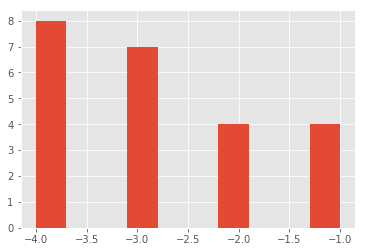

In [34]:
plt.hist(df.STAROST[np.logical_and(df.STAROST >= -1000, df.STAROST < 0)])


Analizirajmo sada i donju skupinu (starosti iz intervala $ \left[ {- 7986} \mathinner{\ldotp \ldotp} {- 7994} \right] $).


In [35]:
df.loc[df.STAROST < -1000]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
38057,235360,2014-09-30,639748,7479194,2014-08-13,2014-08-13,2014-12-09,50000.00,50000.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,False
80261,465175,2011-09-30,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15422303.88,15669257.06,2,1110,FL0202,A,0.0000,B,-7993,False
86903,498580,2012-03-31,991796,4786161,2009-12-02,2014-12-31,NaT,25547376.68,15749562.80,15700407.25,2,1110,FL0202,A,0.0000,B,-7993,False
148126,861346,2011-12-31,163404,6649818,2011-12-30,NaT,NaT,84000.00,NaN,84000.00,1,1430,TM0109,L,2.2000,A,-7993,False
152783,886457,2014-06-30,639748,7479194,2014-02-13,2014-08-13,NaT,50000.00,50000.00,50000.00,1,1430,TM0109,L,0.7181,A,-7991,False
168432,970265,2012-06-30,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7993,True
216361,1249421,2014-12-31,639748,7479194,2014-08-13,2015-02-13,2014-12-09,50000.00,0.00,0.00,1,1430,TM0109,L,1.1072,A,-7990,True
260433,1495035,2012-03-31,991796,4786159,2009-12-02,2012-12-31,NaT,6700951.27,978824.17,975769.19,2,1110,FL0202,A,0.0000,B,-7993,False
303304,1744312,2012-12-31,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7992,True
316395,1819351,2012-09-30,57634,6501553,2011-09-21,2012-03-21,2012-02-27,1000556.77,0.00,0.00,5,1420,TM0109,L,2.4000,A,-7992,True


In [36]:
df.loc[df.STAROST < -1000].shape[0]


In [37]:
df.STAROST[df.STAROST < -1000].describe()


count    3344.000000
mean    -7987.241926
std         1.278142
min     -7994.000000
25%     -7988.000000
50%     -7987.000000
75%     -7987.000000
max     -7986.000000
Name: STAROST, dtype: float64

In [38]:
analiziraj_num_stupac(df.STAROST[df.STAROST < -1000])


{'min': -7994, 'max': -7986, 'range': 8, 'nulls': 0, 'uniques': 9}

(array([  17.,   45.,   38.,   28.,    0.,   18.,   14.,  812., 1596.,
         776.]),
 array([-7994. , -7993.2, -7992.4, -7991.6, -7990.8, -7990. , -7989.2,
        -7988.4, -7987.6, -7986.8, -7986. ]),
 <a list of 10 Patch objects>)

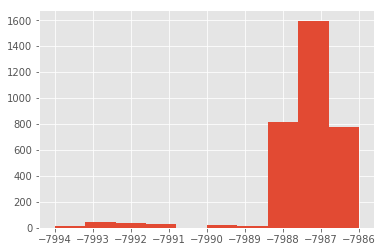

In [39]:
plt.hist(df.STAROST[df.STAROST < -1000])


Neobično je, također, i što postoji starost veća (ne nužno strogo) od $ 900 $ godina. Zapravo, pozitivne starosti su također polarizirane u intervale $ \left[ 1 \mathinner{\ldotp \ldotp} 107 \right] $ i $ \left[ 900 \mathinner{\ldotp \ldotp} 908 \right] $. Naravno da je moguće da je neko poduzeće staro $ 900 $-tinjak godina, ali prvi moderni bankari bili su križari &mdash; to bi značilo da su najstariji suvremeni klijenti *RBA* bankarske usluge mogli tražiti još od prvih bankara na svijetu. Za razliku od negativne starosti, ovaj fenomen nije nemoguć, ali vrlo je malo vjerojatan.

Promotrimo, dakle, te dijelove tablice.


In [40]:
df.loc[df.STAROST >= 500]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
255736,1470486,2014-06-30,633817,7146342,2014-02-07,2014-08-07,2014-05-13,18894.93,19242.86,0.00,2,1430,TM0109,L,0.2636,A,903,True
448131,2564228,2014-03-31,633817,7146342,2014-02-07,2014-02-07,NaT,18894.93,19190.72,19242.86,2,1430,TM0109,L,0.2636,A,903,False
473275,2700372,2012-12-31,633817,7146342,2012-08-07,2013-02-07,NaT,18894.93,18718.60,18959.51,2,1430,TM0109,L,2.3877,A,902,False
495918,2840944,2012-09-30,633817,7146342,2012-08-07,NaT,NaT,18894.93,NaN,18718.60,2,1430,TM0109,L,2.3877,A,901,False
594746,3404719,2013-09-30,633817,7146342,2013-08-07,2013-08-07,NaT,18894.93,18722.62,19125.27,2,1430,TM0109,L,0.3636,A,902,False
643347,3676001,2012-06-30,390595,6090636,2011-05-26,2012-02-02,2012-03-02,21068.94,0.00,0.00,1,1430,FL0900,A,9.7000,C,901,False
653454,3730966,2011-09-30,390595,6090636,2011-05-26,2012-05-28,NaT,21068.94,19479.30,14170.05,1,1430,FL0900,A,9.7000,C,900,False
918389,5248415,2013-03-31,633817,7146342,2013-02-07,2013-02-07,NaT,18894.93,18959.51,19062.79,2,1430,TM0109,L,0.7800,A,902,False
1069017,6109939,2012-12-31,390595,6090636,2011-05-26,2012-02-02,2012-03-02,21068.94,0.00,0.00,1,1430,FL0900,A,9.7000,C,902,False
1138169,6495991,2011-06-30,390595,6090636,2011-05-26,NaT,NaT,21068.94,NaN,19479.30,1,1430,FL0900,A,9.7000,C,900,False


In [41]:
df.loc[df.STAROST >= 500].shape[0]


In [42]:
df.STAROST[df.STAROST >= 500].describe()


count    467.000000
mean     903.304069
std        2.234543
min      900.000000
25%      901.000000
50%      903.000000
75%      905.000000
max      908.000000
Name: STAROST, dtype: float64

In [43]:
analiziraj_num_stupac(df.STAROST[df.STAROST >= 500])


{'min': 900, 'max': 908, 'range': 8, 'nulls': 0, 'uniques': 9}

(array([55., 76., 62., 47.,  0., 69., 77., 35., 37.,  9.]),
 array([900. , 900.8, 901.6, 902.4, 903.2, 904. , 904.8, 905.6, 906.4,
        907.2, 908. ]),
 <a list of 10 Patch objects>)

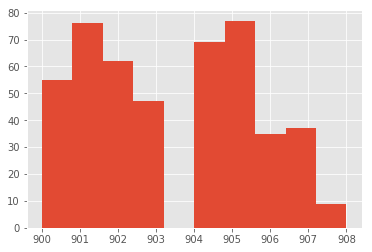

In [44]:
plt.hist(df.STAROST[df.STAROST >= 500])


Osim što nam je sumnjiva negativna i ekstremno velika starost, primijetimo i sljedeće: u stupcu *PLANIRANI_DATUM_ZATVARANJA* postoje nedefinirane vrijednosti &mdash; kako možemo znati koliko je proizvod zatvoren prije isteka ugovorenog roka ako nam taj rok nije poznat?

Pa, promotrimo i takve retke.


In [45]:
df.loc[pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA)]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
19,176,2012-12-31,153516,7348248,2012-12-29,NaT,NaT,25895.53,NaN,25895.53,2,1410,TM0109,L,2.1000,A,53,False
20,182,2012-12-31,13195,7329822,2012-12-06,NaT,NaT,225726.87,NaN,226368.72,2,1410,TM0109,L,3.2000,A,54,False
31,301,2012-12-31,1182607,7278057,2012-11-25,NaT,NaT,10000.00,NaN,10000.00,1,1610,TM0109,L,3.6000,A,28,False
39,324,2012-12-31,1126830,7343742,2012-12-24,NaT,NaT,100177.93,NaN,100356.80,2,1430,TM0109,L,0.1089,A,5,False
57,434,2012-12-31,907604,7347815,2012-12-14,NaT,NaT,12895.00,NaN,12895.00,1,1410,TM0109,L,3.9000,A,55,False
58,436,2012-12-31,1329863,7352534,2012-12-24,NaT,NaT,25703.21,NaN,25703.21,1,1410,TM0109,L,4.0000,A,58,False
70,509,2013-12-31,823258,9132557,2013-12-16,NaT,NaT,14000.00,NaN,14000.00,1,1410,TM0109,L,2.7000,A,30,False
74,526,2013-12-31,711942,9128499,2013-12-17,NaT,NaT,5197.00,NaN,5197.00,1,1410,FL1100,A,NaN,A,40,False
96,665,2013-12-31,1130176,9133552,2013-12-27,NaT,NaT,152703.10,NaN,152752.86,2,1410,TM0109,L,2.6500,A,61,False
98,679,2013-12-31,373096,9093391,2013-11-29,NaT,NaT,100000.00,NaN,99496.26,1,1410,FL0801,A,9.4500,A,51,False


In [46]:
df.loc[pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA)].shape[0]


Konačno, promotrimo i presjeke spomenutih sumnjivih mjesta (negativna ili ekstremno velika starost i nedefinirani planirani datum zatvaranja).


In [47]:
df.loc[np.logical_and(df.STAROST < 0, pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA))]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
146187,850471,2011-12-31,15133,6643434,2011-12-23,NaT,NaT,3.500000e+06,NaN,0.00,1,1120,FL0900,A,6.000,A,-3,False
148126,861346,2011-12-31,163404,6649818,2011-12-30,NaT,NaT,8.400000e+04,NaN,84000.00,1,1430,TM0109,L,2.200,A,-7993,False
567593,3239084,2013-03-31,639748,7479194,2013-02-13,NaT,NaT,5.000000e+04,NaN,50000.00,1,1430,TM0109,L,2.106,A,-7992,False
606561,3472998,2011-09-30,57634,6501553,2011-09-21,NaT,NaT,1.000557e+06,NaN,990851.22,5,1420,TM0109,L,4.800,A,-7993,False
745750,4258948,2011-09-30,57634,6501544,2011-09-20,NaT,2011-09-21,1.006242e+06,NaN,0.00,5,1420,TM0109,L,4.800,A,-7993,False
1525130,10626,2018-06-30,1421922,12930510,2018-04-06,NaT,NaT,7.350000e+03,NaN,7350.00,1,1430,TM0109,L,0.000,A,-7987,False
1702303,425660,2017-06-30,910167,12598090,2017-06-28,NaT,NaT,9.627063e+04,NaN,86009.89,2,1350,TM0104,L,2.000,A,-7988,False
1708168,439993,2011-06-30,1292900,6347768,2011-06-06,NaT,2011-06-28,7.500000e+04,NaN,0.00,1,1320,TM0109,L,0.200,A,-4,False
1713489,453035,2011-06-30,1292900,6085713,2011-05-27,NaT,2011-06-06,7.500000e+04,NaN,0.00,1,1320,TM0109,L,0.200,A,-4,False
1840586,750062,2017-09-30,910167,12612353,2017-07-27,NaT,NaT,1.851762e+05,NaN,184558.20,2,1350,TM0104,L,2.000,A,-7987,False


In [48]:
df.loc[
    np.logical_and(df.STAROST < 0, pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA))
].shape[0]


In [49]:
df.loc[
    np.logical_and(df.STAROST >= 500, pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA))
]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
495918,2840944,2012-09-30,633817,7146342,2012-08-07,NaT,NaT,18894.93,NaN,18718.60,2,1430,TM0109,L,2.3877,A,901,False
1138169,6495991,2011-06-30,390595,6090636,2011-05-26,NaT,NaT,21068.94,NaN,19479.30,1,1430,FL0900,A,9.7000,C,900,False
1564290,97603,2012-09-30,681639,7147009,2012-09-05,NaT,2012-06-09,21501174.86,NaN,0.00,1,1320,TM0109,L,2.5000,A,901,False
1564782,98717,2012-09-30,537821,7101792,2012-07-16,NaT,2012-07-17,3000245.90,NaN,0.00,1,1320,TM0109,L,1.0000,A,901,False
1607321,199101,2016-09-30,831199,12166907,2016-08-16,NaT,NaT,50000.00,NaN,46067.03,1,1430,FL0900,A,5.9500,A,905,False
1621615,232086,2013-06-30,69748,7737536,2013-05-20,NaT,NaT,1000000.00,NaN,1000000.00,1,1430,TM0104,L,2.1000,A,902,False
1650564,301063,2011-12-31,234487,6601422,2011-12-05,NaT,NaT,78823.49,NaN,79548.19,2,1430,FL0900,A,8.5000,C,901,False
1658580,320331,2016-06-30,831199,11472680,2016-04-07,NaT,NaT,50000.00,NaN,50301.23,1,1430,FL0900,A,7.3500,A,905,False
1796972,647791,2012-09-30,69748,7192525,2012-09-12,NaT,NaT,0.00,NaN,0.00,1,1430,TM0109,L,4.0000,A,901,False
1807951,673408,2017-12-31,537820,12707295,2017-10-30,NaT,2017-11-28,2100000.00,NaN,0.00,1,1320,TM0500,A,0.3400,A,907,False


In [50]:
df.loc[
    np.logical_and(df.STAROST >= 500, pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA))
].shape[0]


In [51]:
df.loc[
    np.logical_and(
        np.logical_or(df.STAROST < 0, df.STAROST >= 500),
        pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA)
    )
]


,Unnamed: 0.1,DATUM_IZVJESTAVANJA,KLIJENT_ID,OZNAKA_PARTIJE,DATUM_OTVARANJA,PLANIRANI_DATUM_ZATVARANJA,DATUM_ZATVARANJA,UGOVORENI_IZNOS,STANJE_NA_KRAJU_PRETH_KVARTALA,STANJE_NA_KRAJU_KVARTALA,VALUTA,VRSTA_KLIJENTA,PROIZVOD,VRSTA_PROIZVODA,VISINA_KAMATE,TIP_KAMATE,STAROST,PRIJEVREMENI_RASKID
146187,850471,2011-12-31,15133,6643434,2011-12-23,NaT,NaT,3500000.00,NaN,0.00,1,1120,FL0900,A,6.0000,A,-3,False
148126,861346,2011-12-31,163404,6649818,2011-12-30,NaT,NaT,84000.00,NaN,84000.00,1,1430,TM0109,L,2.2000,A,-7993,False
495918,2840944,2012-09-30,633817,7146342,2012-08-07,NaT,NaT,18894.93,NaN,18718.60,2,1430,TM0109,L,2.3877,A,901,False
567593,3239084,2013-03-31,639748,7479194,2013-02-13,NaT,NaT,50000.00,NaN,50000.00,1,1430,TM0109,L,2.1060,A,-7992,False
606561,3472998,2011-09-30,57634,6501553,2011-09-21,NaT,NaT,1000556.77,NaN,990851.22,5,1420,TM0109,L,4.8000,A,-7993,False
745750,4258948,2011-09-30,57634,6501544,2011-09-20,NaT,2011-09-21,1006241.58,NaN,0.00,5,1420,TM0109,L,4.8000,A,-7993,False
1138169,6495991,2011-06-30,390595,6090636,2011-05-26,NaT,NaT,21068.94,NaN,19479.30,1,1430,FL0900,A,9.7000,C,900,False
1525130,10626,2018-06-30,1421922,12930510,2018-04-06,NaT,NaT,7350.00,NaN,7350.00,1,1430,TM0109,L,0.0000,A,-7987,False
1564290,97603,2012-09-30,681639,7147009,2012-09-05,NaT,2012-06-09,21501174.86,NaN,0.00,1,1320,TM0109,L,2.5000,A,901,False
1564782,98717,2012-09-30,537821,7101792,2012-07-16,NaT,2012-07-17,3000245.90,NaN,0.00,1,1320,TM0109,L,1.0000,A,901,False


In [52]:
df.loc[
    np.logical_and(
        np.logical_or(df.STAROST < 0, df.STAROST >= 500),
        pd.isnull(df.PLANIRANI_DATUM_ZATVARANJA)
    )
].shape[0]
